<a href="https://colab.research.google.com/github/AbdoulayeDiop/plant-classification-with-pretrained-ResNet50/blob/main/plant_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# urls = [
#     f"https://www.cvl.isy.liu.se/en/research/datasets/swedish-leaf/leaf{i}.zip" \
#     for i in range(1, 16)
# ]

# with open("urls.txt", "w") as f:
#   for url in urls:
#     f.write(f"{url}\n")

In [3]:
# !mkdir downloads
# !wget -i urls.txt -P downloads/
# !unzip 'downloads/*.zip' -d drive/MyDrive/Datasets/SwedishLeaf/

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from torchvision import datasets, transforms
from PIL import Image
import torch
import gradio as gr

# IMG_DIR = "/content/drive/MyDrive/Colab Notebooks/Datasets/SwedishLeaf"
IMG_DIR = "G:\Mon Drive\Colab Notebooks\Datasets\SwedishLeaf"
MODEL_PATH = 'G:\Mon Drive\Colab Notebooks\Models\swedish_leaf.pth'

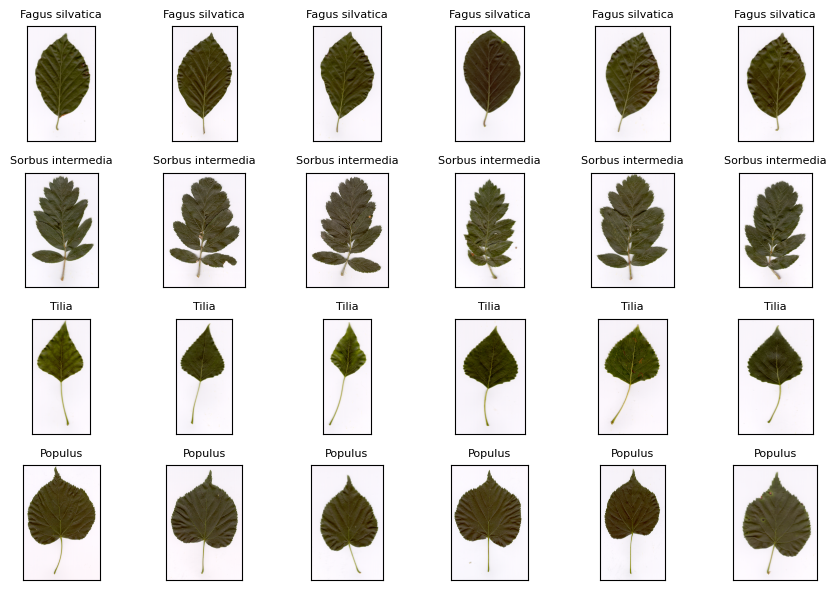

In [5]:
nrows = 4
ncols = 6
plt.figure(figsize=(ncols*1.5, nrows*1.5))
classes = os.listdir(IMG_DIR)
for row in range(nrows):
  class_name = classes[row]
  img_paths = [os.path.join(IMG_DIR, class_name, filename)
    for filename in os.listdir(os.path.join(IMG_DIR, class_name))]
  for col in range(ncols):
    plt.subplot(nrows, ncols, row*ncols + col + 1)
    img = plt.imread(img_paths[col])
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(class_name, fontsize=8)
plt.tight_layout()
plt.show()

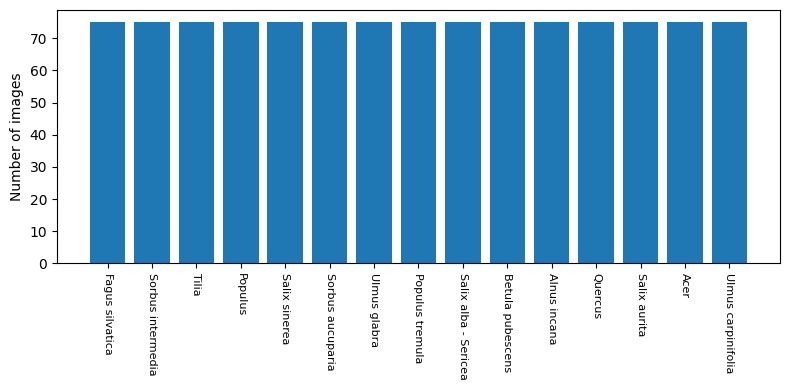

In [6]:
plt.figure(figsize=(8, 4))
class_counts = {class_name: len(os.listdir(os.path.join(IMG_DIR, class_name))) for class_name in os.listdir(IMG_DIR)}

plt.bar(class_counts.keys(), class_counts.values())
plt.ylabel("Number of images")
plt.xticks(rotation=-90, fontsize=8)
plt.tight_layout()
plt.show()

# Training

In [3]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
device

'cuda:0'

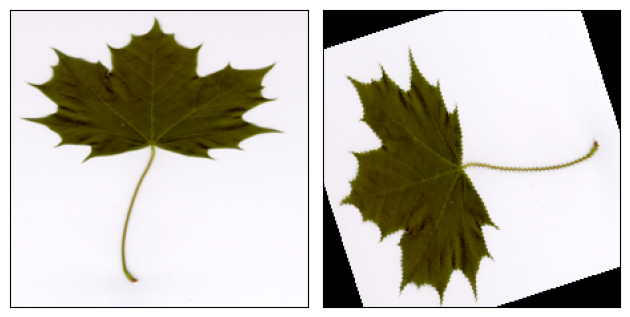

In [8]:
original_img = Image.open(os.path.join(IMG_DIR, "Acer/l2nr001.tif"))
resized_img = transforms.Resize((224, 224))(original_img)
transformed_img = transforms.RandomRotation(180)(resized_img)
imgs = [resized_img, transformed_img]

nrows = 1
ncols = len(imgs)
for col, img in enumerate(imgs):
  plt.subplot(nrows, ncols, col + 1)
  plt.imshow(np.asarray(img))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()

In [9]:
from torchvision.models import resnet50, ResNet50_Weights
def get_resnet50():
  model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
  model.fc = torch.nn.Linear(model.fc.in_features, 15)
  torch.nn.init.xavier_uniform_(model.fc.weight)
  return model

In [10]:
def finetune(model, epochs, train_dataloader, optimizer, loss_function, val_dataloader=None, checkpoint_epochs=5, max_epochs_without_imp=2):
  history = {
      "loss": {
          "train": [],
          "val": []
      },
      "accuracy": {
          "train": [],
          "val": []
      }
  }
  epochs_without_imp = 0
  for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}", end="\t-\t")

    model.train()  # put network in train mode for Dropout and Batch Normalization
    train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
    train_accuracy = torch.tensor(0., device=device)
    for X, y in train_dataloader:
      X = X.to(device)
      y = y.to(device)
      ypred = model(X)
      loss = loss_function(ypred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      with torch.no_grad():
        train_loss += loss*train_dataloader.batch_size
        train_accuracy += (torch.argmax(ypred, dim=1) == y).sum()

    history["loss"]["train"].append(train_loss.item()/len(train_dataloader.dataset))
    history["accuracy"]["train"].append(train_accuracy.item()/len(train_dataloader.dataset))
    print(f"train loss: {history['loss']['train'][-1]:.2f}", end=", ")
    print(f"train acc: {history['accuracy']['train'][-1]:.2f}", end="\t-\t")

    if val_dataloader is not None:
      model.eval()
      val_loss = torch.tensor(0., device=device)
      val_accuracy = torch.tensor(0., device=device)
      with torch.no_grad():
        for X, y in val_dataloader:
          X = X.to(device)
          y = y.to(device)
          ypred = model(X)
          loss = loss_function(ypred, y)
          val_loss += loss * val_dataloader.batch_size
          val_accuracy += (torch.argmax(ypred, dim=1) == y).sum()

      history["loss"]["val"].append(val_loss.item()/len(val_dataloader.dataset))
      history["accuracy"]["val"].append(val_accuracy.item()/len(val_dataloader.dataset))
      print(f"val loss: {history['loss']['val'][-1]:.2f}", end=", ")
      print(f"val acc: {history['accuracy']['val'][-1]:.2f}")
    # if epoch % checkpoint_epochs == 0:
    #   torch.save({
    #       'epoch': epoch,
    #       'state_dict': model.state_dict(),
    #       'optimizer': optimizer.state_dict(),
    #   }, './checkpoint.pth.tar')

    if epoch >= 2 and history["loss"]["train"][-1] >= history["loss"]["train"][-2]:
      epochs_without_imp += 1
    else:
      epochs_without_imp = 0
    if epochs_without_imp >= max_epochs_without_imp:
      break

  return model, history


In [11]:
transform = transforms.Compose([transforms.Resize(255, antialias=True),
                                transforms.CenterCrop(224),
                                transforms.RandomRotation(180),
                                transforms.ToTensor(),])
dataset = datasets.ImageFolder(IMG_DIR, transform=transform)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, (0.8, 0.1, 0.1))

In [12]:
# from time import time
# import multiprocessing as mp
# for num_workers in range(2, 16, 2):
#   train_loader = torch.utils.data.DataLoader(train_set,shuffle=True,num_workers=num_workers,batch_size=64,pin_memory=True)
#   start = time()
#   for epoch in range(1, 3):
#       for i, data in enumerate(train_loader, 0):
#           pass
#   end = time()
#   print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

In [13]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

lr, weight_decay, epochs = 1e-3, 1e-4, 10
model = get_resnet50().to(device)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr, weight_decay=weight_decay)
loss_function = torch.nn.CrossEntropyLoss()

In [14]:
model, history = finetune(model, epochs, train_dataloader, optimizer, loss_function, val_dataloader=val_dataloader)

Epoch 1/10	-	train loss: 1.96, train acc: 0.59	-	val loss: 1.25, val acc: 0.88
Epoch 2/10	-	train loss: 0.99, train acc: 0.91	-	val loss: 0.75, val acc: 0.96
Epoch 3/10	-	train loss: 0.64, train acc: 0.94	-	val loss: 0.53, val acc: 0.96
Epoch 4/10	-	train loss: 0.47, train acc: 0.96	-	val loss: 0.43, val acc: 0.94
Epoch 5/10	-	train loss: 0.37, train acc: 0.96	-	val loss: 0.34, val acc: 0.96
Epoch 6/10	-	train loss: 0.29, train acc: 0.97	-	val loss: 0.32, val acc: 0.95
Epoch 7/10	-	train loss: 0.26, train acc: 0.97	-	val loss: 0.25, val acc: 0.98
Epoch 8/10	-	train loss: 0.22, train acc: 0.98	-	val loss: 0.22, val acc: 0.97
Epoch 9/10	-	train loss: 0.22, train acc: 0.97	-	val loss: 0.19, val acc: 0.97
Epoch 10/10	-	train loss: 0.19, train acc: 0.98	-	val loss: 0.15, val acc: 0.98


In [27]:
torch.save(model, MODEL_PATH)

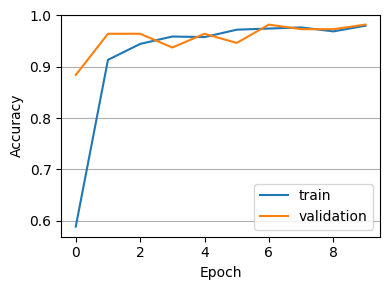

In [16]:
plt.figure(figsize=(4, 3))
plt.plot(history["accuracy"]["train"], label="train")
plt.plot(history["accuracy"]["val"], label="validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(axis="y")
plt.legend()
plt.tight_layout()
plt.show()

# Test

In [8]:
classes = os.listdir(IMG_DIR)
class_names = dict(zip(range(len(classes)), sorted(classes)))
class_names

{0: 'Acer',
 1: 'Alnus incana',
 2: 'Betula pubescens',
 3: 'Fagus silvatica',
 4: 'Populus',
 5: 'Populus tremula',
 6: 'Quercus',
 7: 'Salix alba - Sericea',
 8: 'Salix aurita',
 9: 'Salix sinerea',
 10: 'Sorbus aucuparia',
 11: 'Sorbus intermedia',
 12: 'Tilia',
 13: 'Ulmus carpinifolia',
 14: 'Ulmus glabra'}

In [28]:
saved_model = torch.load(MODEL_PATH)
saved_model.eval()
with torch.no_grad():
  preds = saved_model(torch.stack([x for x, y in test_set]).to(device)).cpu().detach().numpy()
preds = np.argmax(preds, axis=1)

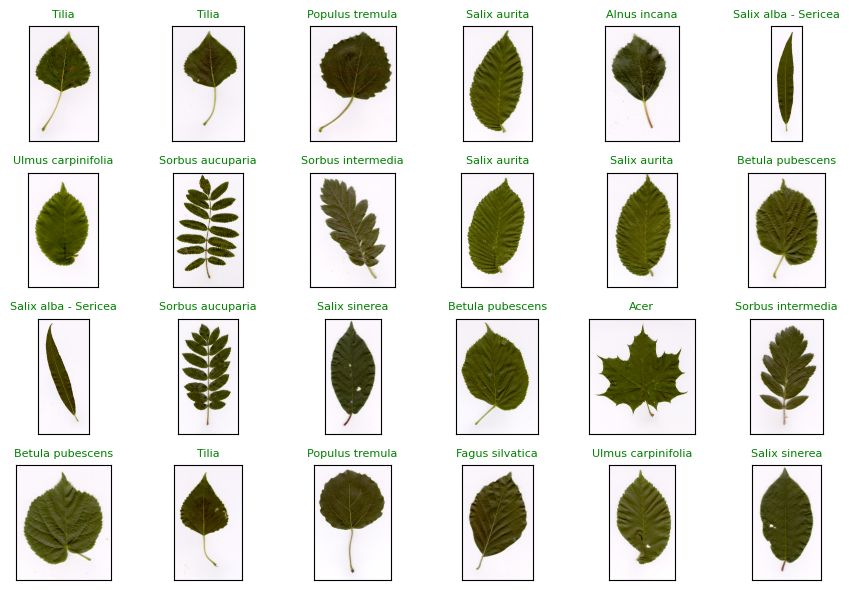

In [31]:
nrows = 4
ncols = 6
nimgs = nrows*ncols
plt.figure(figsize=(ncols*1.5, nrows*1.5))
i = 1
for img_path, label in np.array(dataset.imgs)[test_set.indices][:nimgs]:
  label = int(label)
  class_name = class_names[label]
  pred_label = preds[i-1]
  pred_class_name = class_names[pred_label]
  plt.subplot(nrows, ncols, i)
  img_number = col + 1
  img = plt.imread(img_path)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.title(class_name if pred_label==label else f"{pred_class_name}\n({class_name})",
            fontsize=8, color="green" if pred_label==label else "red")
  i+=1
plt.tight_layout()
plt.show()

In [9]:
model = torch.load(MODEL_PATH)
def prediction(img):
  t = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize(224, antialias=True)
  ])
  new_img = t(img)
  model.eval()
  with torch.no_grad():
    preds = model(torch.stack([new_img]).to(device)).cpu().detach().numpy()
  return class_names[np.argmax(preds, axis=1)[0]]

i=0
img_path = os.path.join(IMG_DIR, "Acer/l2nr001.tif")
img = Image.open(img_path)
prediction(img)

'Acer'

In [10]:
demo = gr.Interface(prediction, gr.Image(), "text")
demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
